# Homework 6 -  Conditional Variational Autoencoder (CVAE) 

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5%20-%20ResNet.ipynb and the previously mentioned link. 



In [2]:
# Download and unzip images
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

# Combine val and train datasets 
!mkdir -p ./hymenoptera_data/combined/ants
!cp ./hymenoptera_data/val/ants/* ./hymenoptera_data/combined/ants
!cp ./hymenoptera_data/train/ants/* ./hymenoptera_data/combined/ants

!mkdir -p ./hymenoptera_data/combined/bees
!cp ./hymenoptera_data/val/bees/* ./hymenoptera_data/combined/bees
!cp ./hymenoptera_data/train/bees/* ./hymenoptera_data/combined/bees

--2020-07-24 15:20:09--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.50.63, 13.226.50.77, 13.226.50.98, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.50.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  59.2MB/s    in 0.8s    

2020-07-24 15:20:10 (59.2 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

# load images and normalize + augment data
data_transforms = {
    'combined': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['combined']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['combined']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['combined']}
class_names = image_datasets['combined'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)
print(class_names)

{'combined': 397}
['ants', 'bees']



c) Show a few images from the dataset so we understand what we are working with. 



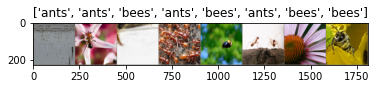

In [9]:
# explore the data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['combined']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 



e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training.





In [5]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 50
batch_size = 8
capacity = 32
variational_beta = 1
img_size = inputs.shape[3] # 224

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # use an embedding layer for the layer
        self.label_emb = nn.Embedding(2, img_size*img_size)
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 112 x 112 --> (224 - 4 + 2(1) / 2) + 1 = 111 + 1 = 112
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c*2 x 56 x 56 --> (112 - 4 + 2(1) / 2) + 1 = 55 + 1 = 56
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1) # out: c*4 x 28 x 28 --> (56 - 4 + 2(1) / 2) + 1 = 27 + 1 = 28
        self.conv4 = nn.Conv2d(in_channels=c*4, out_channels=c*8, kernel_size=4, stride=2, padding=1) # out: c*8 x 14 x 14 --> (28 - 4 + 2(1) / 2) + 1 = 13 + 1 = 14
        self.conv5 = nn.Conv2d(in_channels=c*8, out_channels=c*16, kernel_size=4, stride=2, padding=1) # out: c*16 x 7 x 7 --> (16 - 4 + 2(1) / 2) + 1 = 6 + 1 = 7
        self.fc_mu = nn.Linear(in_features=c*16*7*7, out_features=latent_dims) # out: latent_dims
        self.fc_logvar = nn.Linear(in_features=c*16*7*7, out_features=latent_dims) # out: latent_dims
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 224*224)
        c = c.view(-1, 1, 224, 224) # (batch_size, 1, 224, 224)
        x = torch.cat([x, c], axis=1) # (batch_size, 4, 224, 224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        # notice, here we use use x for mu and for variance! 
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x) #we don't calculate this from x_mu but from x!! This is crutial. 
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # use an embedding layer for the layer
        self.label_emb = nn.Embedding(2, 1)
        c = capacity
        self.fc1 = nn.Linear(in_features=latent_dims+1, out_features=c*16*7*7)
        self.conv5 = nn.ConvTranspose2d(in_channels=c*16, out_channels=c*8, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=c*8, out_channels=c*4, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 1)
        x = torch.cat([x, c], axis=1) # (batch_size, latent_dims+1)
        x = self.fc1(x)
        x = x.view(x.size(0), capacity*16, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        return x 

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x, labels):
        # remember our encoder output consists of x_mu and x_logvar
        latent_mu, latent_logvar = self.encoder(x, labels)
        # we sample from the distributions defined by mu and logvar
        # (function latent_sample defined below)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, labels)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_() #define normal distribution
            return eps.mul(std).add_(mu) #sample from normal distribution
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.mse_loss(recon_x.view(-1, 3*224*224), x.view(-1, 3*224*224), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence

VariationalAutoencoder(
  (encoder): Encoder(
    (label_emb): Embedding(2, 50176)
    (conv1): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=25088, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=25088, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (label_emb): Embedding(2, 1)
    (fc1): Linear(in_features=51, out_features=25088, bias=True)
    (conv5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

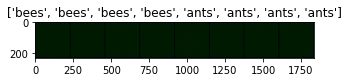

Epoch [2 / 200] average reconstruction error: 1678429.482500
Epoch [3 / 200] average reconstruction error: 1611425.360000
Epoch [4 / 200] average reconstruction error: 1521945.061250
Epoch [5 / 200] average reconstruction error: 1425471.926250
Epoch [6 / 200] average reconstruction error: 1126146.107500
Epoch [7 / 200] average reconstruction error: 1020972.552500
Epoch [8 / 200] average reconstruction error: 965970.218750
Epoch [9 / 200] average reconstruction error: 902573.935625
Epoch [10 / 200] average reconstruction error: 809052.312500
Epoch [11 / 200] average reconstruction error: 807743.463750


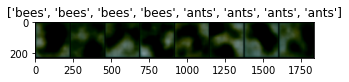

Epoch [12 / 200] average reconstruction error: 756838.169375
Epoch [13 / 200] average reconstruction error: 742228.124375
Epoch [14 / 200] average reconstruction error: 728001.678750
Epoch [15 / 200] average reconstruction error: 718061.016250
Epoch [16 / 200] average reconstruction error: 692070.012500
Epoch [17 / 200] average reconstruction error: 678559.479375
Epoch [18 / 200] average reconstruction error: 674497.570000
Epoch [19 / 200] average reconstruction error: 652762.916250
Epoch [20 / 200] average reconstruction error: 634189.091875
Epoch [21 / 200] average reconstruction error: 638062.545000


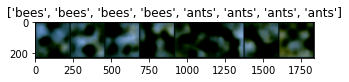

Epoch [22 / 200] average reconstruction error: 623492.672500
Epoch [23 / 200] average reconstruction error: 613963.345625
Epoch [24 / 200] average reconstruction error: 595614.893125
Epoch [25 / 200] average reconstruction error: 607638.261250
Epoch [26 / 200] average reconstruction error: 580229.091875
Epoch [27 / 200] average reconstruction error: 571395.580625
Epoch [28 / 200] average reconstruction error: 592051.215625
Epoch [29 / 200] average reconstruction error: 565877.145625
Epoch [30 / 200] average reconstruction error: 563275.562500
Epoch [31 / 200] average reconstruction error: 566656.741250


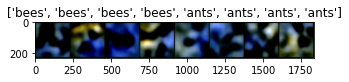

Epoch [32 / 200] average reconstruction error: 567735.358750
Epoch [33 / 200] average reconstruction error: 540161.225313
Epoch [34 / 200] average reconstruction error: 559666.738125
Epoch [35 / 200] average reconstruction error: 555378.725625
Epoch [36 / 200] average reconstruction error: 551861.043750
Epoch [37 / 200] average reconstruction error: 540137.766250
Epoch [38 / 200] average reconstruction error: 546960.642500
Epoch [39 / 200] average reconstruction error: 535120.577500
Epoch [40 / 200] average reconstruction error: 533710.181250
Epoch [41 / 200] average reconstruction error: 534806.560937


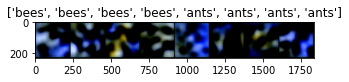

Epoch [42 / 200] average reconstruction error: 531719.114375
Epoch [43 / 200] average reconstruction error: 521206.940000
Epoch [44 / 200] average reconstruction error: 523437.131250
Epoch [45 / 200] average reconstruction error: 524199.908750
Epoch [46 / 200] average reconstruction error: 531555.311875
Epoch [47 / 200] average reconstruction error: 525253.023125
Epoch [48 / 200] average reconstruction error: 515120.048125
Epoch [49 / 200] average reconstruction error: 501793.765000
Epoch [50 / 200] average reconstruction error: 517762.354375
Epoch [51 / 200] average reconstruction error: 524739.647500


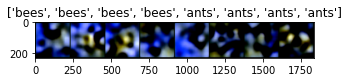

Epoch [52 / 200] average reconstruction error: 511063.616875
Epoch [53 / 200] average reconstruction error: 506876.513125
Epoch [54 / 200] average reconstruction error: 504615.261875
Epoch [55 / 200] average reconstruction error: 504418.990000
Epoch [56 / 200] average reconstruction error: 513249.733750
Epoch [57 / 200] average reconstruction error: 503940.876875
Epoch [58 / 200] average reconstruction error: 502340.398750
Epoch [59 / 200] average reconstruction error: 500562.904062
Epoch [60 / 200] average reconstruction error: 501563.069375
Epoch [61 / 200] average reconstruction error: 508549.265000


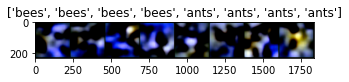

Epoch [62 / 200] average reconstruction error: 512801.387500
Epoch [63 / 200] average reconstruction error: 502259.729687
Epoch [64 / 200] average reconstruction error: 496528.295625
Epoch [65 / 200] average reconstruction error: 501134.813125
Epoch [66 / 200] average reconstruction error: 504085.091875
Epoch [67 / 200] average reconstruction error: 497547.942500
Epoch [68 / 200] average reconstruction error: 492550.593125
Epoch [69 / 200] average reconstruction error: 500164.211875
Epoch [70 / 200] average reconstruction error: 494741.479375
Epoch [71 / 200] average reconstruction error: 494916.341250


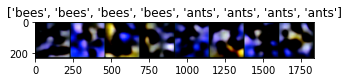

Epoch [72 / 200] average reconstruction error: 501297.188750
Epoch [73 / 200] average reconstruction error: 512607.331875
Epoch [74 / 200] average reconstruction error: 501782.777500
Epoch [75 / 200] average reconstruction error: 507921.361250
Epoch [76 / 200] average reconstruction error: 507903.611250
Epoch [77 / 200] average reconstruction error: 499262.654375
Epoch [78 / 200] average reconstruction error: 497427.958125
Epoch [79 / 200] average reconstruction error: 490445.036250
Epoch [80 / 200] average reconstruction error: 502604.405625
Epoch [81 / 200] average reconstruction error: 495782.705625


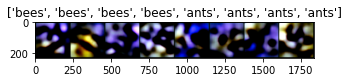

Epoch [82 / 200] average reconstruction error: 483620.529375
Epoch [83 / 200] average reconstruction error: 494380.160625
Epoch [84 / 200] average reconstruction error: 494531.505937
Epoch [85 / 200] average reconstruction error: 492220.923750
Epoch [86 / 200] average reconstruction error: 494451.211875
Epoch [87 / 200] average reconstruction error: 489208.513125
Epoch [88 / 200] average reconstruction error: 491171.788438
Epoch [89 / 200] average reconstruction error: 487376.147500
Epoch [90 / 200] average reconstruction error: 487643.255312
Epoch [91 / 200] average reconstruction error: 480104.690625


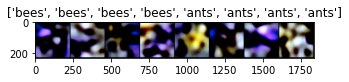

Epoch [92 / 200] average reconstruction error: 498493.111563
Epoch [93 / 200] average reconstruction error: 490609.283750
Epoch [94 / 200] average reconstruction error: 484589.370625
Epoch [95 / 200] average reconstruction error: 492496.746250
Epoch [96 / 200] average reconstruction error: 486364.464375
Epoch [97 / 200] average reconstruction error: 477368.895625
Epoch [98 / 200] average reconstruction error: 478459.438125
Epoch [99 / 200] average reconstruction error: 469571.688125
Epoch [100 / 200] average reconstruction error: 466727.111563
Epoch [101 / 200] average reconstruction error: 471296.680625


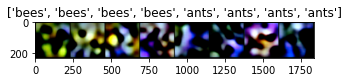

Epoch [102 / 200] average reconstruction error: 469055.368437
Epoch [103 / 200] average reconstruction error: 459434.230000
Epoch [104 / 200] average reconstruction error: 444183.808750
Epoch [105 / 200] average reconstruction error: 461096.002500
Epoch [106 / 200] average reconstruction error: 438884.548750
Epoch [107 / 200] average reconstruction error: 450308.555312
Epoch [108 / 200] average reconstruction error: 444463.337813
Epoch [109 / 200] average reconstruction error: 439099.239375
Epoch [110 / 200] average reconstruction error: 451992.384375
Epoch [111 / 200] average reconstruction error: 454425.726875


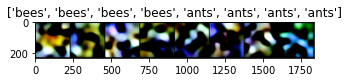

Epoch [112 / 200] average reconstruction error: 451944.100000
Epoch [113 / 200] average reconstruction error: 449792.641250
Epoch [114 / 200] average reconstruction error: 447134.519062
Epoch [115 / 200] average reconstruction error: 441728.732187
Epoch [116 / 200] average reconstruction error: 435348.759375
Epoch [117 / 200] average reconstruction error: 440424.118750
Epoch [118 / 200] average reconstruction error: 434382.127500
Epoch [119 / 200] average reconstruction error: 441965.311875
Epoch [120 / 200] average reconstruction error: 445268.091875
Epoch [121 / 200] average reconstruction error: 431499.976875


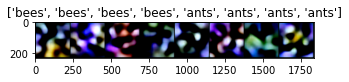

Epoch [122 / 200] average reconstruction error: 438655.325625
Epoch [123 / 200] average reconstruction error: 437796.838125
Epoch [124 / 200] average reconstruction error: 439920.552187
Epoch [125 / 200] average reconstruction error: 444536.850000
Epoch [126 / 200] average reconstruction error: 436601.652500
Epoch [127 / 200] average reconstruction error: 441666.925000
Epoch [128 / 200] average reconstruction error: 430811.392813
Epoch [129 / 200] average reconstruction error: 447285.800625
Epoch [130 / 200] average reconstruction error: 426627.430000
Epoch [131 / 200] average reconstruction error: 435792.931250


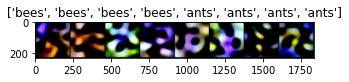

Epoch [132 / 200] average reconstruction error: 436739.901250
Epoch [133 / 200] average reconstruction error: 438711.376875
Epoch [134 / 200] average reconstruction error: 433956.119063
Epoch [135 / 200] average reconstruction error: 428667.945625
Epoch [136 / 200] average reconstruction error: 425991.483750
Epoch [137 / 200] average reconstruction error: 426772.960938
Epoch [138 / 200] average reconstruction error: 425347.156562
Epoch [139 / 200] average reconstruction error: 437035.779375
Epoch [140 / 200] average reconstruction error: 436098.537500
Epoch [141 / 200] average reconstruction error: 432042.582188


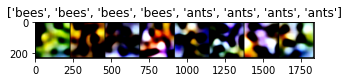

Epoch [142 / 200] average reconstruction error: 439191.140313
Epoch [143 / 200] average reconstruction error: 434670.580000
Epoch [144 / 200] average reconstruction error: 422302.526562
Epoch [145 / 200] average reconstruction error: 430687.840625
Epoch [146 / 200] average reconstruction error: 425132.561875
Epoch [147 / 200] average reconstruction error: 435377.595313
Epoch [148 / 200] average reconstruction error: 439494.622500
Epoch [149 / 200] average reconstruction error: 433759.835000
Epoch [150 / 200] average reconstruction error: 435897.664375
Epoch [151 / 200] average reconstruction error: 436494.577500


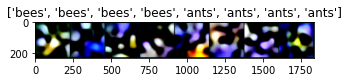

Epoch [152 / 200] average reconstruction error: 427928.593750
Epoch [153 / 200] average reconstruction error: 426025.770313
Epoch [154 / 200] average reconstruction error: 426063.292812
Epoch [155 / 200] average reconstruction error: 428687.439063
Epoch [156 / 200] average reconstruction error: 434865.583750
Epoch [157 / 200] average reconstruction error: 432494.907500
Epoch [158 / 200] average reconstruction error: 438745.766875
Epoch [159 / 200] average reconstruction error: 430654.009688
Epoch [160 / 200] average reconstruction error: 435692.856875
Epoch [161 / 200] average reconstruction error: 433374.307812


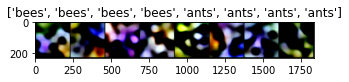

Epoch [162 / 200] average reconstruction error: 427149.561875
Epoch [163 / 200] average reconstruction error: 425839.944063
Epoch [164 / 200] average reconstruction error: 428829.868750
Epoch [165 / 200] average reconstruction error: 436078.390000
Epoch [166 / 200] average reconstruction error: 432494.528125
Epoch [167 / 200] average reconstruction error: 430771.331875
Epoch [168 / 200] average reconstruction error: 433065.377500
Epoch [169 / 200] average reconstruction error: 431768.755625
Epoch [170 / 200] average reconstruction error: 432526.442188
Epoch [171 / 200] average reconstruction error: 421894.732500


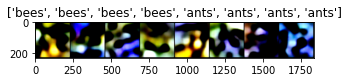

Epoch [172 / 200] average reconstruction error: 426291.454688
Epoch [173 / 200] average reconstruction error: 431778.577500
Epoch [174 / 200] average reconstruction error: 430014.848125
Epoch [175 / 200] average reconstruction error: 425740.565937
Epoch [176 / 200] average reconstruction error: 433390.106250
Epoch [177 / 200] average reconstruction error: 431514.025313
Epoch [178 / 200] average reconstruction error: 430100.500937
Epoch [179 / 200] average reconstruction error: 419114.192812
Epoch [180 / 200] average reconstruction error: 426028.116875
Epoch [181 / 200] average reconstruction error: 422865.910000


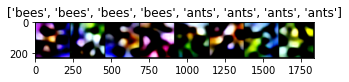

Epoch [182 / 200] average reconstruction error: 426807.851250
Epoch [183 / 200] average reconstruction error: 421684.195000
Epoch [184 / 200] average reconstruction error: 423584.511875
Epoch [185 / 200] average reconstruction error: 417965.390000
Epoch [186 / 200] average reconstruction error: 428688.357500
Epoch [187 / 200] average reconstruction error: 418298.037500
Epoch [188 / 200] average reconstruction error: 415315.634375
Epoch [189 / 200] average reconstruction error: 423719.280938
Epoch [190 / 200] average reconstruction error: 427275.751875
Epoch [191 / 200] average reconstruction error: 431155.569688


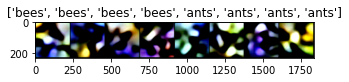

Epoch [192 / 200] average reconstruction error: 425448.040000
Epoch [193 / 200] average reconstruction error: 418786.673750
Epoch [194 / 200] average reconstruction error: 427987.539375
Epoch [195 / 200] average reconstruction error: 418388.471875
Epoch [196 / 200] average reconstruction error: 422836.285938
Epoch [197 / 200] average reconstruction error: 423938.070625
Epoch [198 / 200] average reconstruction error: 413838.542812
Epoch [199 / 200] average reconstruction error: 425263.895625
Epoch [200 / 200] average reconstruction error: 419889.524062


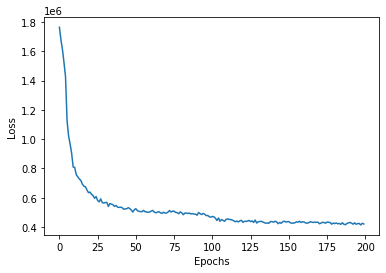

In [6]:
# train the network
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img, classes):
    img = to_img(img)
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    plt.title(classes)
    plt.imshow(img)

num_epochs = 200
use_gpu = True
learning_rate = 1e-4
sample_size = 8

vae = VariationalAutoencoder().to(device)
print(vae)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    # set to training mode
    vae.train()
    train_loss_avg.append(0)  
    num_batches = 0 
    for i, (image_batch, labels) in enumerate(dataloaders['combined']):        
        image_batch = image_batch.to(device)
        labels = labels.to(device)
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch, labels)        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()        
        train_loss_avg[-1] += loss.item()    
        num_batches += 1    
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

    if epoch % 10 == 0:
        vae.eval()
        with torch.no_grad():
            # sample latent vectors from the normal distribution
            latent = torch.randn(sample_size, latent_dims).to(device)
            # reconstruct images from the latent vectors
            labels = torch.LongTensor([1,1,1,1,0,0,0,0]).to(device)
            classes = [class_names[i] for i in labels]
            img_recon = vae.decoder(latent, labels)
            img_recon = img_recon.cpu()
            fig, ax = plt.subplots(figsize=(5, 5))
            show_image(torchvision.utils.make_grid(img_recon.data[:8],8,5), classes)
            plt.show()
            
# loss during training
plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

g) Does this model work well enough? What might be the reason for this? 

No, the model does not work well enough. This could be because there is not enough training data for the model to capture relationships that may exists between features.